# Correlazioni tra ETF e spread trading
## Obbiettivi
1. Analizzare ETF di diverso tipo identificando coppie di ETF con correlazioni positive consistenti.

2. Tra le coppie individuate ricercare ed analizzare i periodi in cui la correlazione è momentaneamente cambiata.

3. Valutare la possibilità di applicazione di una strategia di spread trading che sfrutta i periodi di decorrelazione di ETF storicamente correlati. 
    L'obbiettivo dello spread trading è scommettere che i due tornerranno a muoversi insieme andando a guadagnare appunto dalla differenza (spread) che si è momentaneamente presentata. 
    In parole povere:
    - Si vende quello che sovraperforma
    - Si compra quello che sottoperforma
        

---

## 1. Ricerca di ETF con correlazini positive consistenti

### Importazione librerie necessarie

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

### Download datasets dei mercati

In [2]:
# Download serie storiche       
tickers = [
'SPY','TLT',
'GLD','UUP',
'QQQ','VXX',
'SH','IWM',
'SLV','TIP',
'IWM'
]

df = yf.download(tickers, start='2015-01-01', end='2024-12-31', period='1d')

# Visualizziamo le informazioni generali del dataframe 
df.info()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, GLD)   2515 non-null   float64
 1   (Close, IWM)   2515 non-null   float64
 2   (Close, QQQ)   2515 non-null   float64
 3   (Close, SH)    2515 non-null   float64
 4   (Close, SLV)   2515 non-null   float64
 5   (Close, SPY)   2515 non-null   float64
 6   (Close, TIP)   2515 non-null   float64
 7   (Close, TLT)   2515 non-null   float64
 8   (Close, UUP)   2515 non-null   float64
 9   (Close, VXX)   1744 non-null   float64
 10  (High, GLD)    2515 non-null   float64
 11  (High, IWM)    2515 non-null   float64
 12  (High, QQQ)    2515 non-null   float64
 13  (High, SH)     2515 non-null   float64
 14  (High, SLV)    2515 non-null   float64
 15  (High, SPY)    2515 non-null   float64
 16  (High, TIP)    2515 non-null   float64
 17  (High, TLT)    2515 non-null   flo

### Pulizia dataset
Osservando le informazioni generali del dataframe possiamo notare come il mercato VXX abbia notevolmente meno record rispetto agli altri mercati (1744 vs 2515). 

Questo è dovuto alla natura particolare del mercato VXX che determina una minor disponibilità di dati storici rispetto agli altri mercati. 

Al fine di ottenere risultati affidabili da questa analisi si ritene sia importante poter disporre del maggior numero di dati storici disponibili, perciò il VXX verrà escluso dalla nostra analisi.  

Il dataframe presenta i classici valori di prezzo dei mercati: OPEN, HIGH, LOW, CLOSE (OHLC) ed il volume. Per la nostra analisi è sufficiente il prezzo di chiusura giornaliero, andremo quindi a conservare solo tale valore.
Da notare però che quando si scaricano i dati da **yfinance** con più ticker contemporaneamente le colonne diventano MultiIndex (ad esempio: ('Close', 'SPY'), ('Open', 'QQQ'), ecc.). Quindi dovremmo anche andare ad appiattire i nomi delle colonne.

In [3]:
# Conserviamo solo le colonne di 'Close'
close_df = df['Close'].copy()

# Appiattiamo i nomi delle colonne
close_df.columns.name = None

# Rimuoviamo il mercato VXX
close_df.drop(columns=['VXX'], inplace=True)

# Trasformazione Date to dateformat
close_df.index = pd.to_datetime(close_df.index).date

close_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GLD     2515 non-null   float64
 1   IWM     2515 non-null   float64
 2   QQQ     2515 non-null   float64
 3   SH      2515 non-null   float64
 4   SLV     2515 non-null   float64
 5   SPY     2515 non-null   float64
 6   TIP     2515 non-null   float64
 7   TLT     2515 non-null   float64
 8   UUP     2515 non-null   float64
dtypes: float64(9)
memory usage: 196.5+ KB


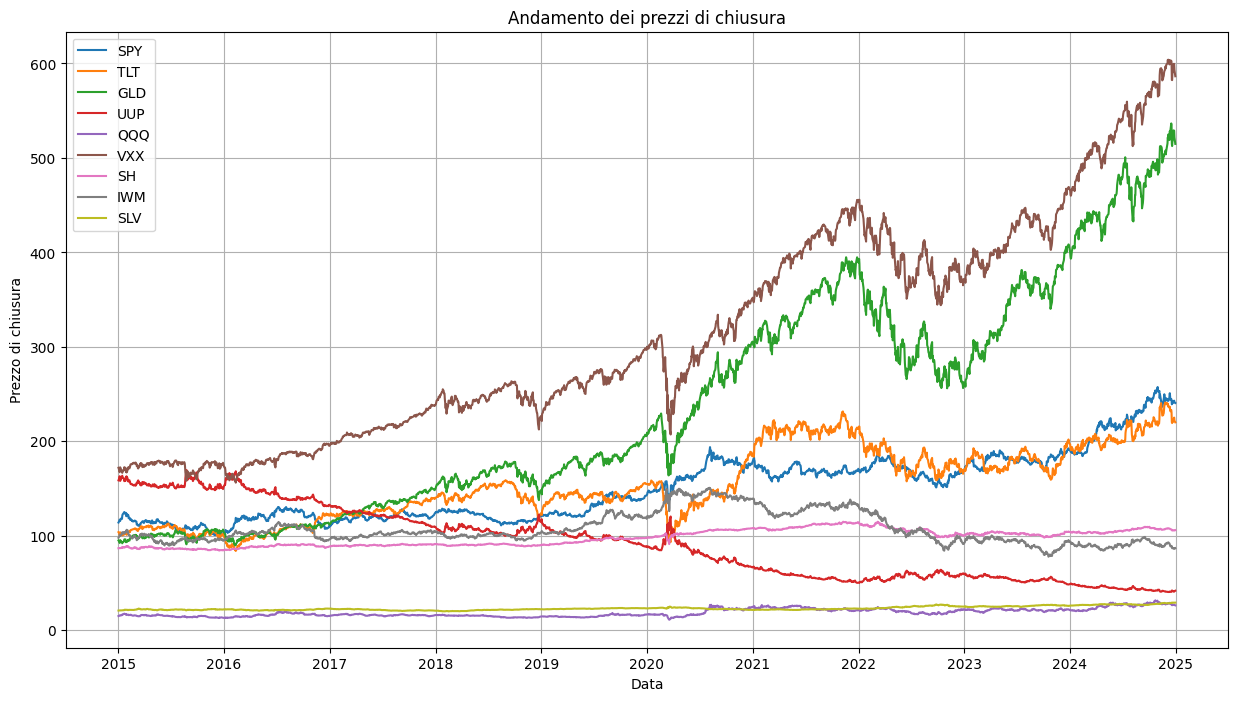

In [4]:
# Visualizzazione dell'andamento dei prezzi di chiusura
close_df.plot(figsize=(15, 8), title='Andamento dei prezzi di chiusura')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura')
plt.legend(tickers, loc='upper left')
plt.grid()
plt.show()

### Normalizzazione per confrontare l’andamento relativo
Visualizzando serie temporali di asset con scale molto diverse, come possiamo vedere dal grafico qua sopra, le serie con valori maggiori "schiacciano" visivamente quelle più piccole.

Trasformando tutte le serie in scala relativa, ad esempio partendo da 1. Possiamo confrontare l'andamento percentuale nel tempo, piuttosto che i valori assoluti.

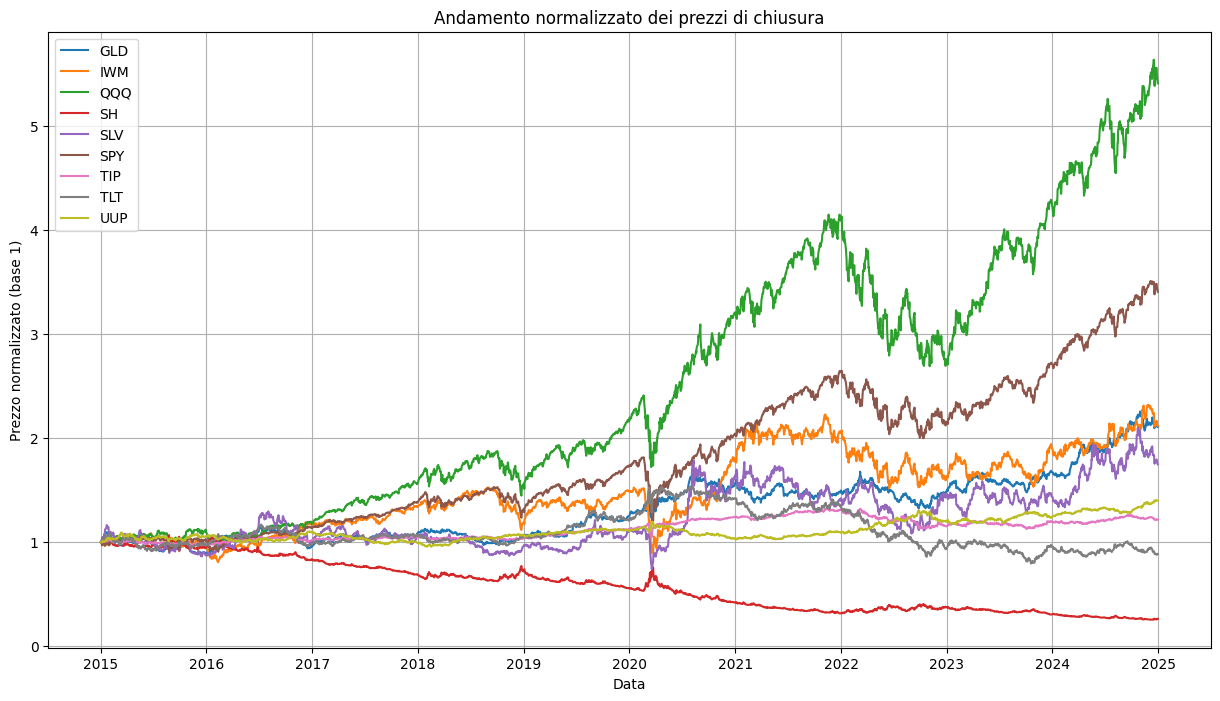

In [5]:
# Normalizzazione di tutti i prezzi in modo che partano da 1
normalized_df = close_df / close_df.iloc[0]

# Visualizzazione dell'andamento normalizzato dei prezzi di chiusura
normalized_df.plot(figsize=(15, 8), title='Andamento normalizzato dei prezzi di chiusura')
plt.xlabel('Data')
plt.ylabel('Prezzo normalizzato (base 1)')
plt.grid()
plt.show()

A vista d'occhio possiamo osservare che la maggior parte dei mercati sono positivamente correlati, con pochi casi di correlazione inversa.

Per verificare questa nostra intuizione andiamo a creare una matrice di correlazione ed una sua visualizzazione tramite una heatmap per meglio individuare le correlazioni tra i mercati

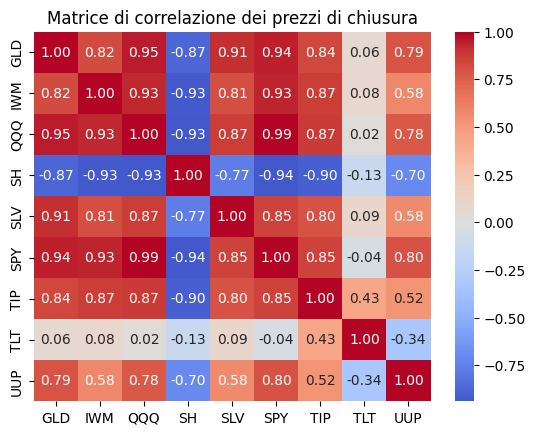

In [6]:
# Calcolo della matrice di correlazione
correlation_mx = close_df.corr()

# Visualizzazione della matrice di correlazione con heatmap
sns.heatmap(correlation_mx, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Matrice di correlazione dei prezzi di chiusura')
plt.show()

### Selezione delle coppie di mercati con una forte correlazione positiva (>= 0.9)

In [7]:
correlation_thrashold = 0.9

# Filtra le correlazioni positive
positive_correlations = correlation_mx[correlation_mx >= correlation_thrashold]

# Rimuovi la diagonale (correlazione con se stessi)
positive_correlations = positive_correlations.where(~np.eye(len(positive_correlations), dtype=bool))

# Stack e rimozione duplicati (A-B e B-A)
etfs_pairs = positive_correlations.stack().reset_index()
etfs_pairs.columns = ['ETF 1', 'ETF 2', 'Correlazione']
etfs_pairs = (etfs_pairs[etfs_pairs['ETF 1'] < etfs_pairs['ETF 2']])

# Ordina i risultati in base alla correlazione
etfs_pairs = etfs_pairs.sort_values(by='Correlazione', ascending=False).reset_index(drop=True)

# Visualizza il risultato
etfs_pairs

,ETF 1,ETF 2,Correlazione
0,QQQ,SPY,0.993884
1,GLD,QQQ,0.949523
2,GLD,SPY,0.943743
3,IWM,SPY,0.931915
4,IWM,QQQ,0.925637
5,GLD,SLV,0.907719


### Commento sulle correlazioni individuate
Possiamo osservare come **QQQ** e **SPY** abbiano una correlazione quasi perfetta. Questo è dovuto alla presenza di asset molto simili nei due ETF. 

Data questa alta correlazione tra **QQQ** e **SPY** possiamo individuare e rimuovere delle coppie "ridondanti". Infatti, sapendo che **GLD** è correlato con **SPY** e che **SPY** è perfettamente correlato con **QQQ**, per la proprietà transitiva si può essere certi che **GLD** avrà una correlazione quasi identica con **QQQ**. (Stessa cosa si puo dire nel caso di **IWM**).

In [8]:
# Rimozione coppie ridondanti (GLD-SPY e IWM-QQQ)
etfs_pairs = etfs_pairs[~(((etfs_pairs['ETF 1'] == 'GLD') & (etfs_pairs['ETF 2'] == 'SPY')) | ((etfs_pairs['ETF 1'] == 'IWM') & (etfs_pairs['ETF 2'] == 'QQQ')))]

# reimposta gli indici
etfs_pairs = etfs_pairs.reset_index(drop=True)

---

## 2. Analisi delle correlazioni
### Correlazione tramite regressione lineare
La correlazione tra due asset può essere vista anche tramite la regressione lineare, andiamo quindi ad usare questa tecnica alternativa per visualizzare la correlazione tra i due asset.

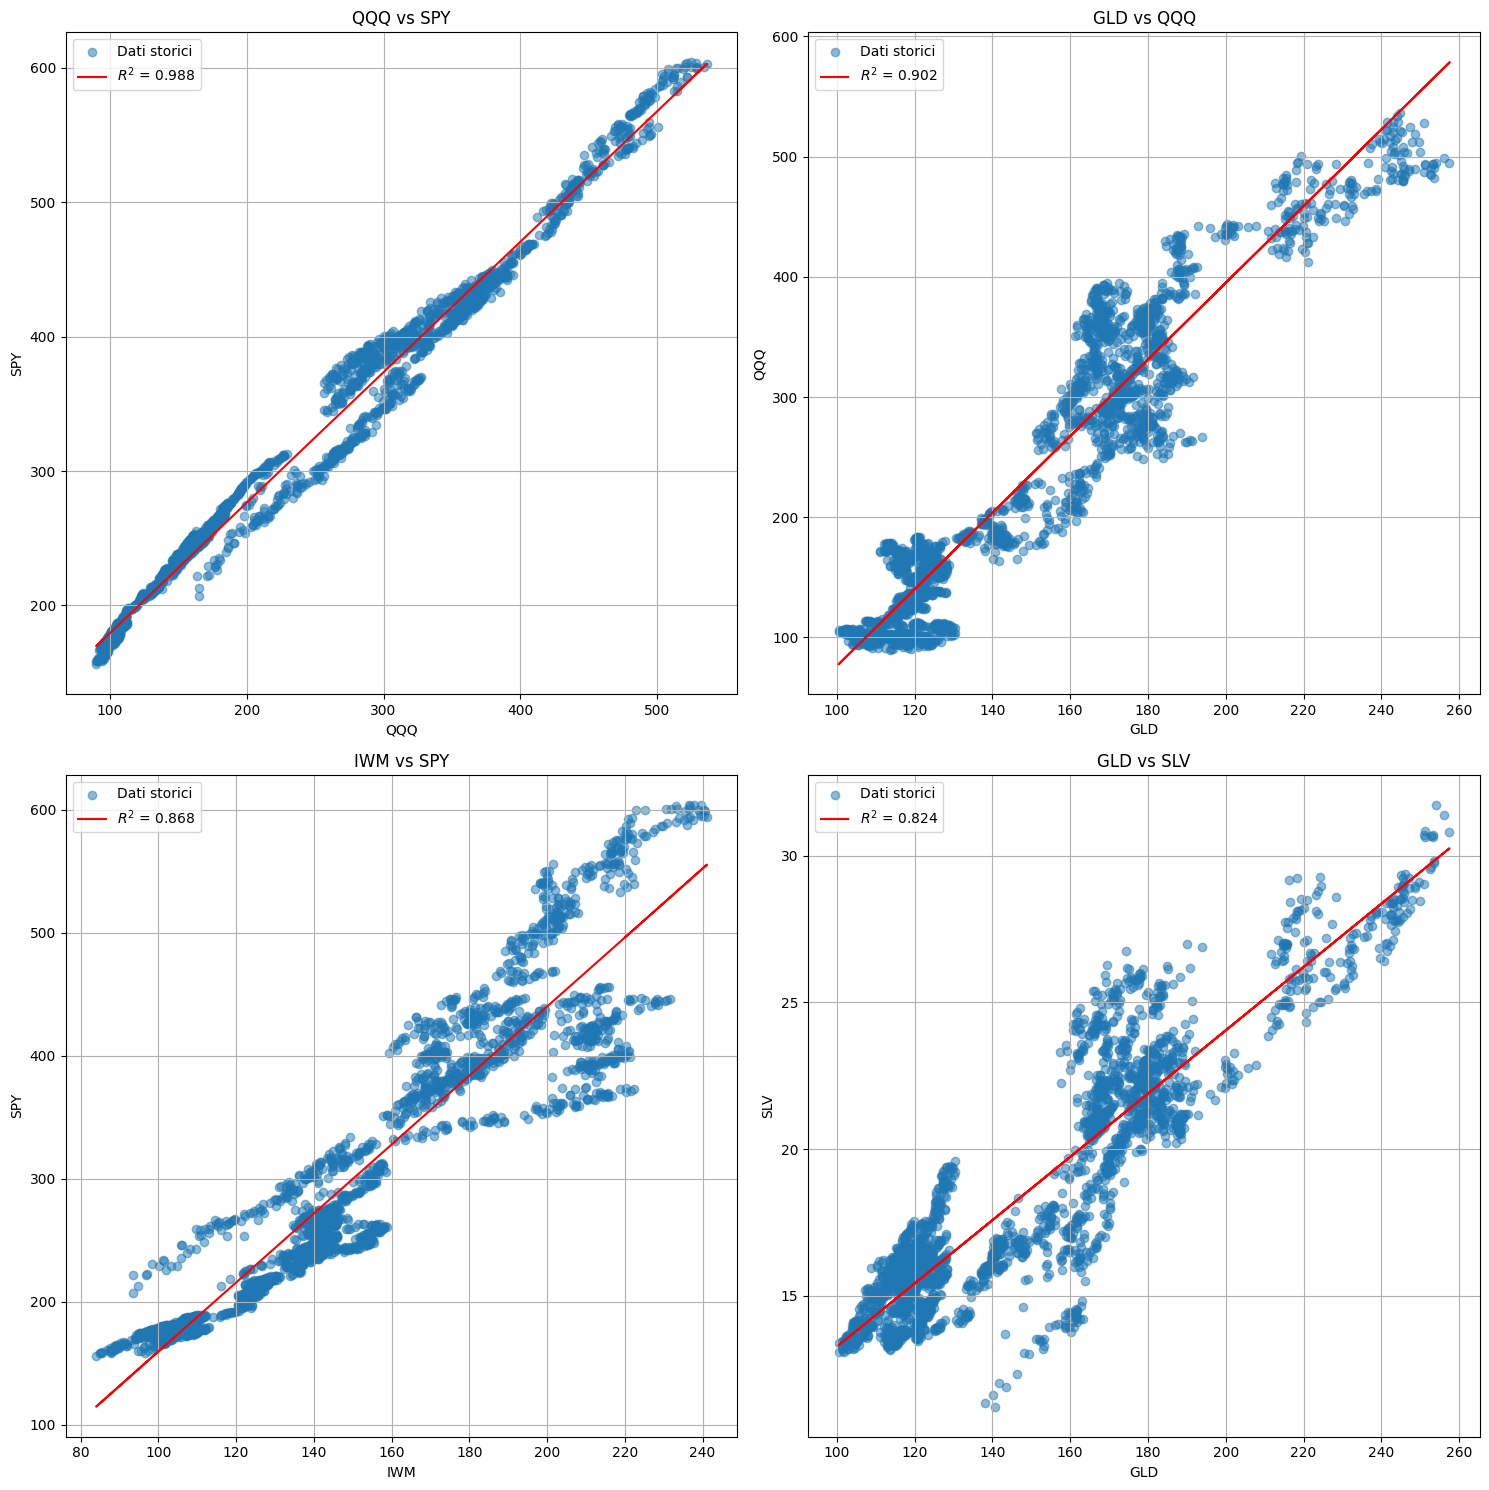

In [9]:
# Imposta la griglia
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Appiattisce la matrice in un array 1D per iterare facilmente
axes = axes.flatten() 

for idx, row in etfs_pairs.iterrows():
    etf1 = row['ETF 1']
    etf2 = row['ETF 2']
    
    # Prepara le variabili indipendenti (x) e dipendenti (y)
    x = close_df[etf1].values.reshape(-1, 1)
    y = close_df[etf2].values

    # Crea e allena il modello di regressione lineare
    model = LinearRegression()
    model.fit(x, y)

    # Calcola il coefficiente di determinazione R² e le predizioni
    r2 = model.score(x, y)
    y_pred = model.predict(x)

    # Disegna scatter plot e retta di regressione
    ax = axes[idx]
    ax.scatter(x, y, alpha=0.5, label='Dati storici')
    ax.plot(x, y_pred, color='red', label=f'$R^2$ = {r2:.3f}')
    ax.set_title(f'{etf1} vs {etf2}')
    ax.set_xlabel(etf1)
    ax.set_ylabel(etf2)
    ax.grid(True)
    ax.legend()

# Aggiusta layout
plt.tight_layout()
plt.show()

### Correlazione Mobile
La correlazione mobile (o rolling correlation) misura come varia nel tempo la correlazione tra due serie storiche, calcolandola su finestre mobili. Quindi per ogni giorno si ottiene una nuova correlazione, basata sugli ultimi *x* giorni.

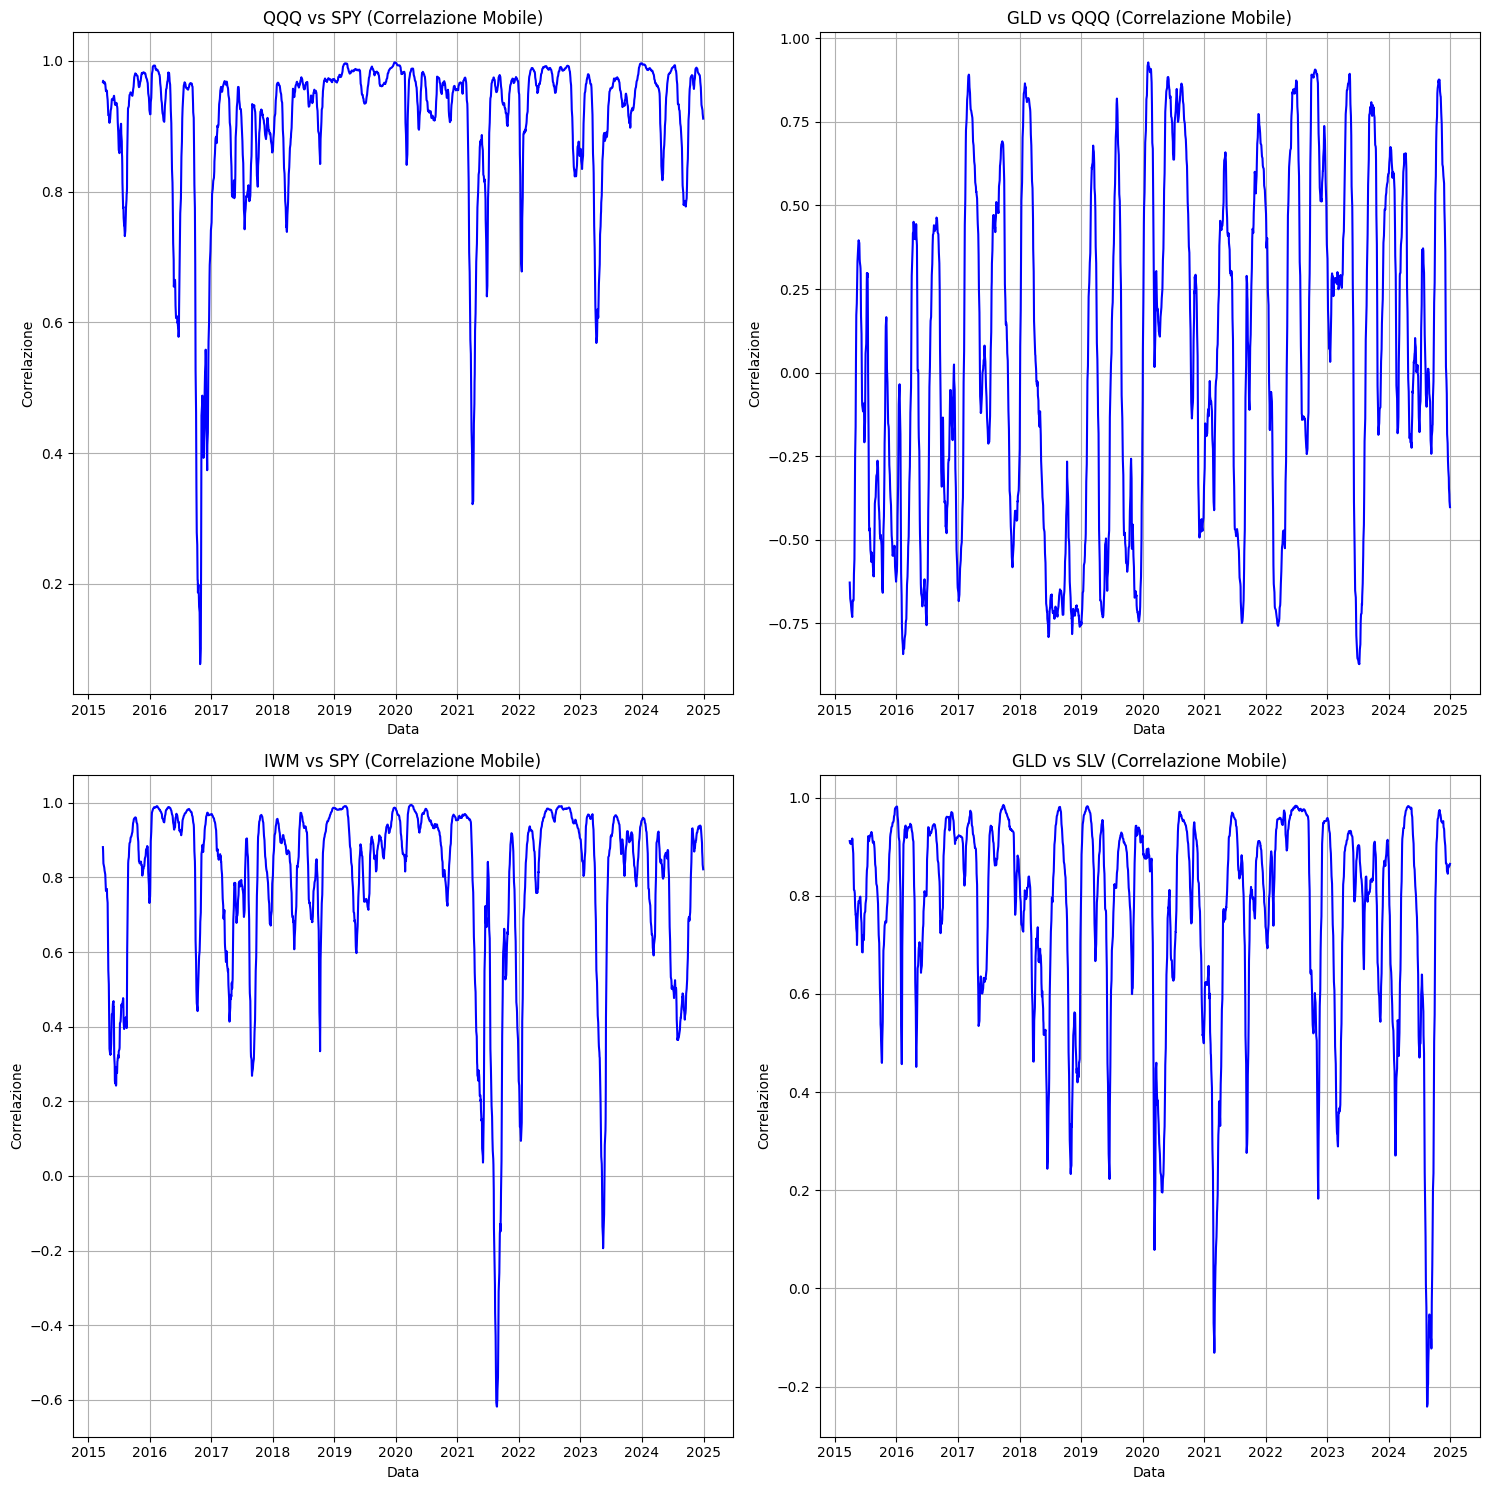

In [ ]:
# Imposta la griglia
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten() 

# Dizionario per memorizzare le rolling correlation
rolling_corr_store = {}

# Parametro della finestra per la rolling correlation
rolling_window = 60

for idx, row in etfs_pairs.iterrows():
    etf1 = row['ETF 1']
    etf2 = row['ETF 2']

    # Calcolo della correlazione mobile tra i due ETF
    rolling_corr = close_df[etf1].rolling(window=rolling_window).corr(close_df[etf2])
    
    # Aggiungi i valori della rolling correlation al dizionario
    rolling_corr_store.update({f'{etf1}-{etf2}': rolling_corr})

    # Disegno della correlazione mobile
    ax = axes[idx]
    rolling_corr.plot(ax=ax, color='blue')
    ax.set_title(f'{etf1} vs {etf2} (Correlazione Mobile)')
    ax.set_xlabel('Data')
    ax.set_ylabel('Correlazione')
    ax.grid(True)

# Aggiusta layout
plt.tight_layout()
plt.show()

### Commento rolling correlation
Una condizione necessaria per applicare una strategia di spread trading vuole che la rolling correlation mostri un grafico che tendenzialmente ritorna verso valore di correlazione alto (1) con dei picchi discendenti che rappresentano momentanei periodi di decorrelazione. 

La coppia **GLD-QQQ** al contrario, presenta una situazione in cui i valori di correlazione ruotano attorno allo 0 indicando che i mercati non sono realmente correlati e quindi non adatti allo spread trading. Questo risultato è perfettamente plausibile essendo la natura dei mercati molto diversa  (oro vs azionario).

Possiamo quindi escludere questa coppia dalla nostra analisi.

In [11]:
# Rimozione coppia dal dizionario delle rolling correlation
rolling_corr_store.pop('GLD-QQQ', None)

# Rimozione coppia non correlata (GLD-QQQ)
etfs_pairs = etfs_pairs[~((etfs_pairs['ETF 1'] == 'GLD') & (etfs_pairs['ETF 2'] == 'QQQ')) ]

# reimposta gli indici
etfs_pairs = etfs_pairs.reset_index(drop=True)

### Visualizzazione dei breakdown di correlazione
Per meglio apprezzare i momenti in cui le coppie di etf perdono la loro correlazione andiamo ad evidenziare a grafico questi periodi.

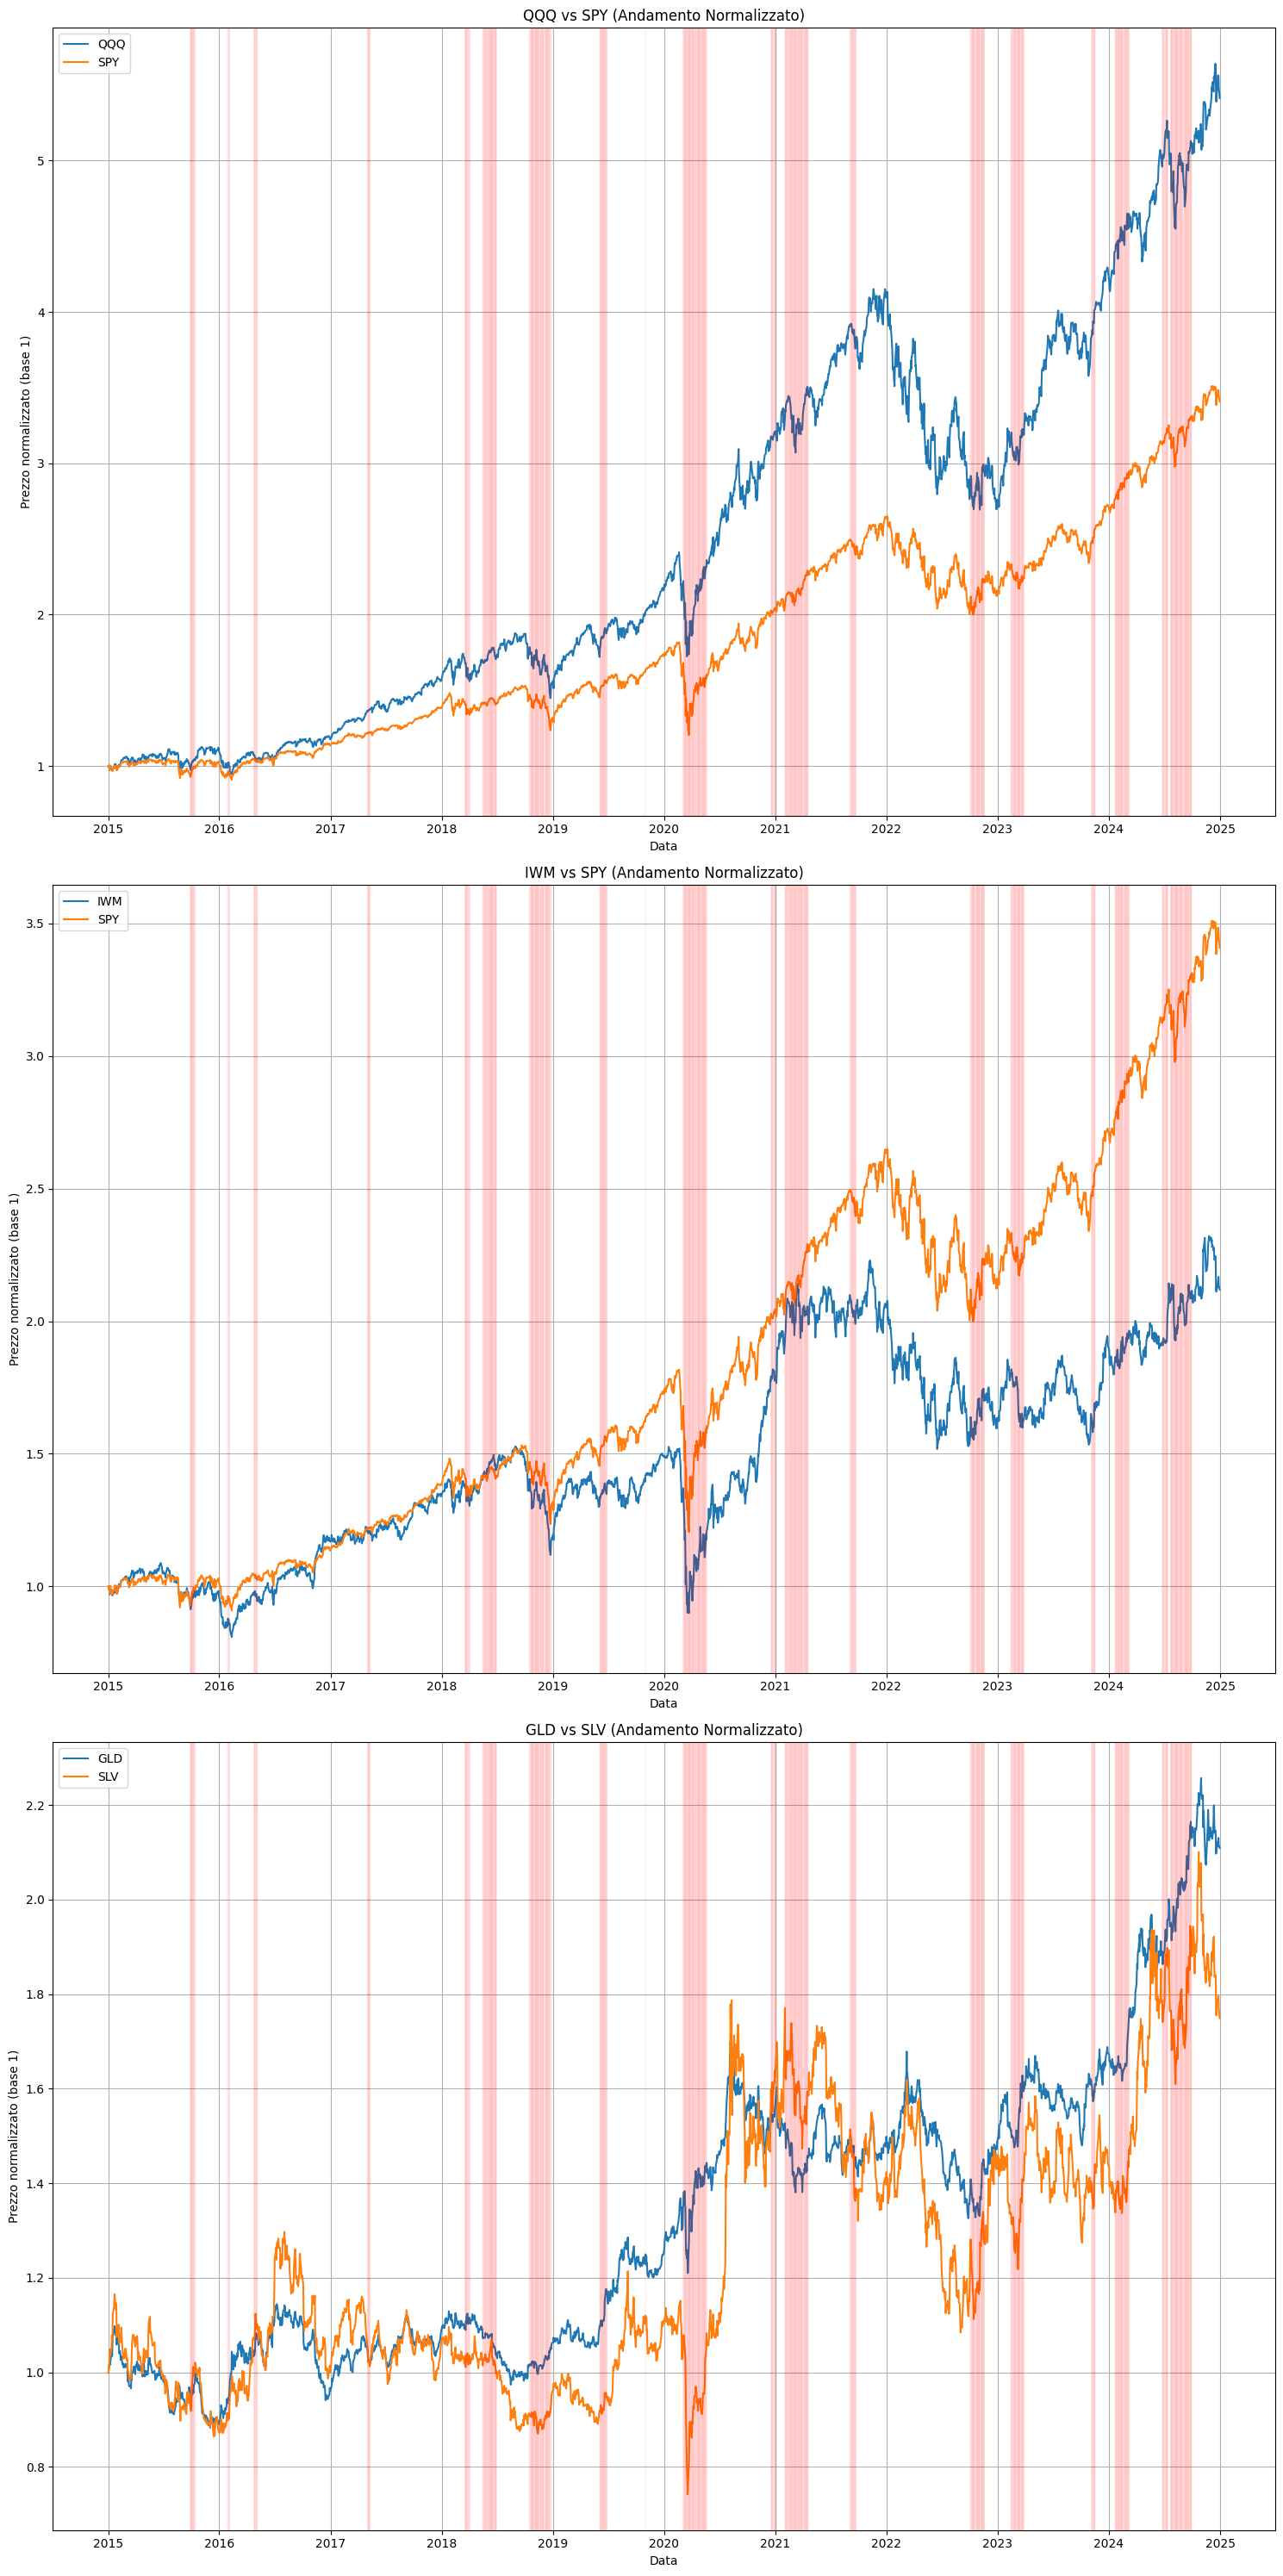

In [12]:
# Definizione della soglia per la bassa correlazione
low_corr_value = 0.6

# Impostazione della griglia per i grafici
fig, axes = plt.subplots(3, 1, figsize=(15, 30)) 
axes = axes.flatten()

# Creazione DataFrame dal dizionario delle rolling correlations
rolling_corr_df = pd.concat(rolling_corr_store, axis=1)

for idx, column in enumerate(rolling_corr_df.columns):
    # Estrae i nomi dei due ETF dalla colonna
    etf1, etf2 = column.split('-')
    
    # Selezione dei giorni in cui la correlazione è scesa sotto la soglia
    low_corr_dates = rolling_corr[rolling_corr < low_corr_value].index

    # Disegno grafico normalizzato
    ax = axes[idx]
    normalized_df[[etf1, etf2]].plot(ax=ax, title=f'Andamento normalizzato {etf1} vs {etf2}')
    
    # Evidenzia i periodi a bassa correlazione
    for date in low_corr_dates:
        ax.axvline(date, color='red', alpha=0.05)  # Linea rossa semi-trasparente

    ax.set_title(f'{etf1} vs {etf2} (Andamento Normalizzato)')
    ax.set_xlabel('Data')
    ax.set_ylabel('Prezzo normalizzato (base 1)')
    ax.grid(True)

# Aggiusta layout
plt.tight_layout()
plt.show()

### Commento sui periodi di decorrelazione
E' interessante notare come, in tutte e tre le coppie di mercati, i periodi di decorrelazione (aree rosse) coincidano. Questo è abbastanza plausibile siccome la decorrelazione è solitamente dovuta a periodi / notizie marco economiche che vanno ad influenzare tutti i mercati.  

### Analisi dello spread tra i prezzi
Una strategia di spread trading ha senso solo se lo spread tende naturalmente a tornare verso la media.

Come controllare?
- Se il grafico dello spread/zscore mostra oscillazioni regolari attorno allo zero, è perfetto.
- Se invece lo spread "scappa" (tipo trend forte e non torna più), allora non va bene.

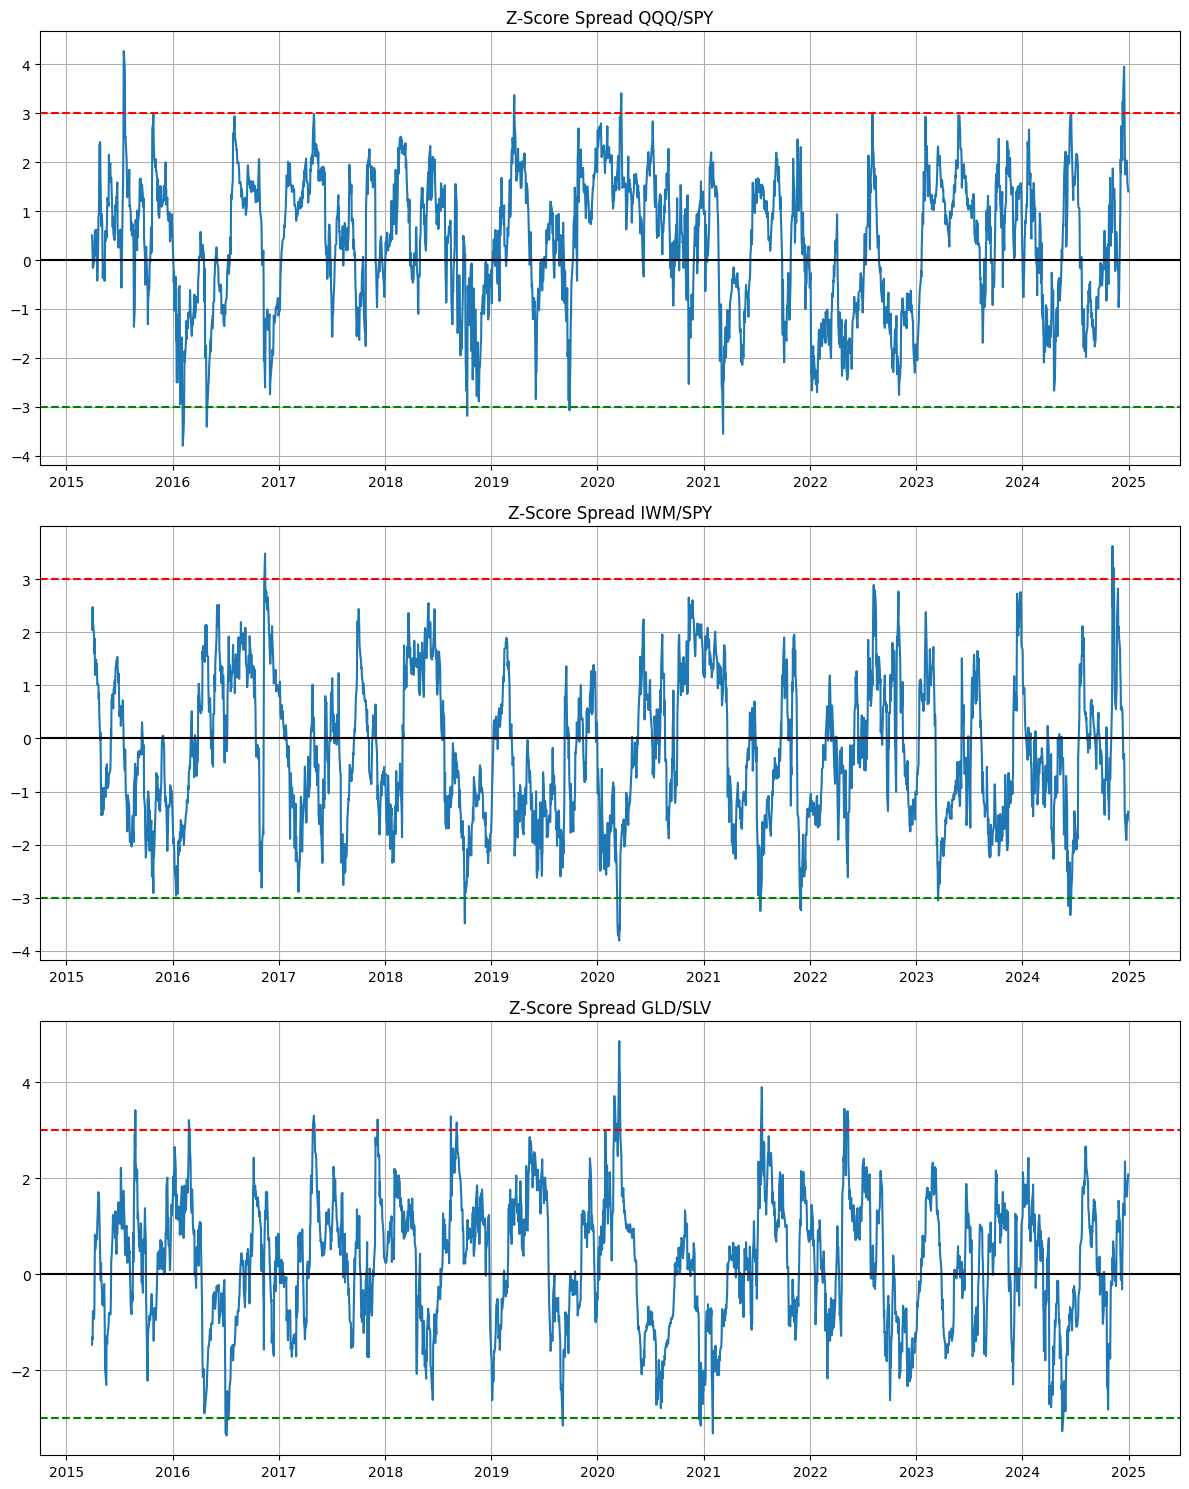

In [13]:
# Impostazione della griglia per i grafici
fig, axes = plt.subplots(3, 1, figsize=(12, 15)) 
axes = axes.flatten()

# Definizione del limite di spread in valore assoluto
spread_limit_abs_value = 3

# Dichiarazione dizionario per memorizzare gli spread e i relativi z-score
spread_zscore_store = {}

for idx, column in enumerate(rolling_corr_df.columns):
    # Estrae i nomi dei due ETF dalla colonna
    etf1, etf2 = column.split('-')

    # Calcola la spread
    spread = close_df[etf1] / close_df[etf2]

    # Media mobile e std mobile
    rolling_mean = spread.rolling(window=rolling_window).mean()
    rolling_std = spread.rolling(window=rolling_window).std()

    # Calcolo dello z-score
    z_score = (spread - rolling_mean) / rolling_std

    # Aggiungi i valori dello spread e dello z-score allo store
    spread_zscore_store.update({f'{etf1}-{etf2}': (spread, z_score)})

    # Disegno grafico normalizzato
    ax = axes[idx]
    z_score.plot(ax=ax, title=f'Z-Score Spread {etf1}/{etf2}')

    ax.axhline(spread_limit_abs_value, color='red', linestyle='--')
    ax.axhline(-spread_limit_abs_value, color='green', linestyle='--')
    ax.axhline(0, color='black', linestyle='-')
    ax.grid()
    
# Visualizza
plt.tight_layout()
plt.show()  

Osservando i grafici dello spread si può confermare la natura mean reverting, per tutte e tre le coppie, e quindi la possibilità di applicare una strategia di spread trading.

---

## 3. Applicazione della strategia e valutazione delle performance
Nello specifico la strategia che andremo ad applicare seguira queste semplici regole:
- Ogni volta che lo z-score supera +3 o -3, entra in posizione.
- Quando lo z-score torna a 0 o oltre, chiude la posizione e registra il profitto o la perdita.

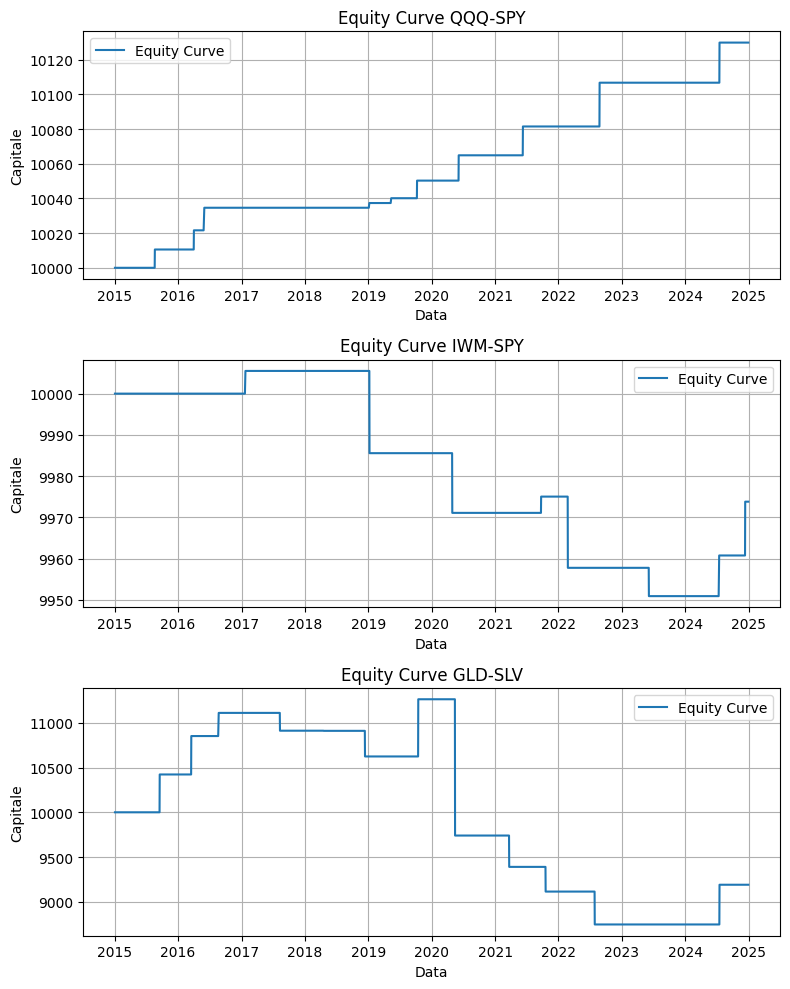

In [15]:
# Import backtester
from backtester import Backtester

# Impostazione della griglia per i grafici
fig, axes = plt.subplots(3, 1, figsize=(8, 10)) 
axes = axes.flatten()

for idx, key in enumerate(spread_zscore_store.keys()):
    spread, z_score = spread_zscore_store[key]

    # Backtest della strategia
    backtester = Backtester(spread=spread, zscore=z_score, zscore_threshold=spread_limit_abs_value, initial_capital=10000)
    backtester.run()

    # Disegno grafico equity curve
    ax = axes[idx]
    ax.plot(spread.index, backtester.equity_curve, label='Equity Curve')
    ax.set_title(f'Equity Curve {key}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Capitale')
    ax.grid()
    ax.legend()

# Visualizza l'equity curve
plt.tight_layout()
plt.show()

## Conclusioni finali
**IWM-SPY** e **GLD-SLV** evidenziano performance negative.

La coppia **QQQ-SPY** mostra una equity curve positive andando a confermare che è effettivamente possibile implemetare una strategia profittevole che sfutta la momentanea decorrelazione di mercati storicamente correlati.

Tuttavia, questi risultati sono preliminari: il valore di **zscore_threshold** e **rolling_window** potrebbero essere ottimizzati ulteriormente. 

Inoltre, i test non considerano costi di transazione né slippage, fattori che potrebbero influenzare significativamente le performance reali.